In [2]:
ls

drive/  sample_data/


In [3]:
cd/content/drive/MyDrive/Assignment 3

/content/drive/MyDrive/Assignment 3


In [4]:
ls


'Assignment 3.ipynb'   flowers/   Flowers-Dataset.zip   test/


In [5]:
pwd


'/content/drive/MyDrive/Assignment 3'

In [7]:
!unzip Flowers-Dataset.zip

Archive:  Flowers-Dataset.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/daisy/10555826524_423eb8bf71_n.jpg  
  infla

In [8]:
import os
import shutil
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from pathlib import Path

In [9]:
# Data visualisation 
import pandas as pd 
import seaborn as sns


In [10]:
from PIL import Image
from skimage.io import imread
import cv2
from tensorflow.keras.utils import to_categorical

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import numpy as np 

In [12]:
# Plotting library
from mpl_toolkits.mplot3d import Axes3D  # needed to plot 3-D surfaces

In [13]:
# dl libraries specifically for CNN
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import optimizers

In [14]:
# Tells matplotlib to embed plots within the notebook
%matplotlib inline

import math

In [15]:
# Dataset folder
flowersPath = Path('/content/drive/MyDrive/Assignment 3/flowers')

In [16]:
# Each species of flower is contained in a separate folder, & this is to get all the sub-directories
flowers = os.listdir(flowersPath)
print("Number of types of flowers: ", len(flowers))
print("Types of flowers: ", flowers)

Number of types of flowers:  5
Types of flowers:  ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [17]:
# A list which contains tuples, the type of flower and the corresponding image path
flowersList = []

In [18]:
for species in flowers:
    # Get all the file names
    allFlowers = os.listdir(flowersPath / species)
    # Add them to the list
    for flower in allFlowers:
        flowersList.append((species, str(flowersPath /species) + '/' + flower))

In [19]:
# Build a dataframe   
# load the dataset as a pandas data frame     
flowersList = pd.DataFrame(data=flowersList, columns=['category', 'image'], index=None)
flowersList.head()

,category,image
0,daisy,/content/drive/MyDrive/Assignment 3/flowers/da...
1,daisy,/content/drive/MyDrive/Assignment 3/flowers/da...
2,daisy,/content/drive/MyDrive/Assignment 3/flowers/da...
3,daisy,/content/drive/MyDrive/Assignment 3/flowers/da...
4,daisy,/content/drive/MyDrive/Assignment 3/flowers/da...


In [20]:
# Let's check how many samples for each category are present
print("Total number of flowers in the dataset: ", len(flowersList))
flowerNum = flowersList['category'].value_counts()
print("Flowers in each category: ")
print(flowerNum)

Total number of flowers in the dataset:  4317
Flowers in each category: 
dandelion    1052
tulip         984
rose          784
daisy         764
sunflower     733
Name: category, dtype: int64


In [21]:
# A list for storing names of some random samples from each category
RanSamples = []

In [22]:
# Get samples fom each category 
for category in flowerNum.index:
    samples = flowersList['image'][flowersList['category'] == category].sample(4).values
    for sample in samples:
        RanSamples.append(sample)

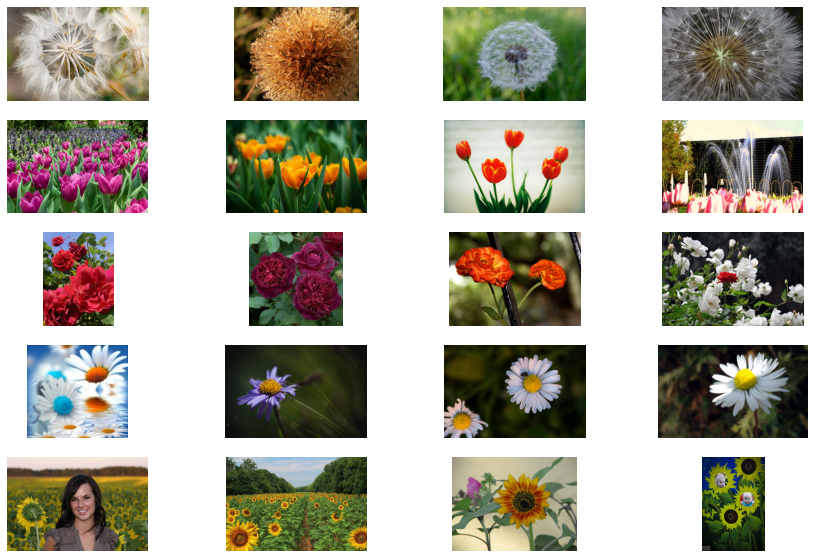

In [23]:
# Plot the samples
f, ax = plt.subplots(5,4, figsize=(15,10))
for i,sample in enumerate(RanSamples):
    ax[i//4, i%4].imshow(mimg.imread(RanSamples[i]))
    ax[i//4, i%4].axis('off')
plt.show()  

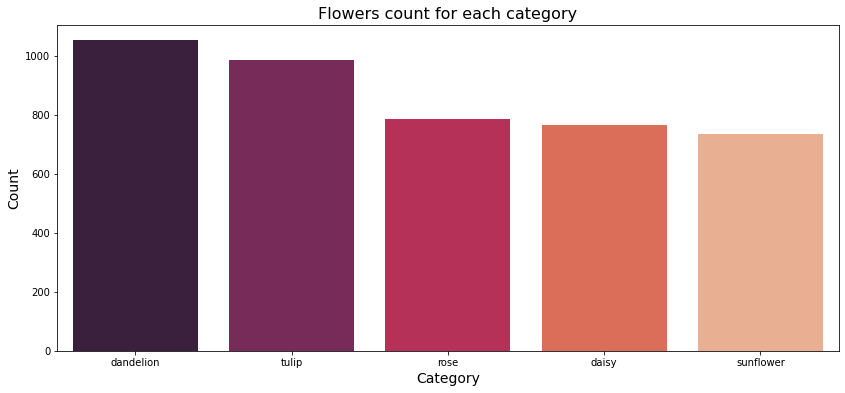

In [24]:
# Let's do some visualization and see how many samples we have for each category
f, axe = plt.subplots(1,1,figsize=(14,6))
sns.barplot(x = flowerNum.index, y = flowerNum.values, ax = axe, palette="rocket")
axe.set_title("Flowers count for each category", fontsize=16)
axe.set_xlabel('Category', fontsize=14)
axe.set_ylabel('Count', fontsize=14)
plt.show()

In [25]:
# Make directory 'test', with 2 sub directories, 'trainDir', & 'validDir'
trainDir = './test/trainDir'
valDir = './test/valDir'
# test_dir = './test/test_dir'
def create_directory(dirName):
    if os.path.exists(dirName):
        shutil.rmtree(dirName)
    os.makedirs(dirName)
    # Inside the trainDir & valDir sub-directories, sub-directories for each flower is created
    for flower in flowers:
        os.makedirs(os.path.join(dirName, flower))
create_directory(trainDir)
create_directory(valDir)

In [26]:
# lists for training & validation image & label
trainImg = []
trainLabel = []
validImg = []
validLabel = []

In [27]:
# for copying 100 samples to the validation dir & others to the train dir
for flower in flowerNum.index:
    samples = flowersList['image'][flowersList['category'] == flower].values
    diffPics = np.random.permutation(samples)
    
    for i in range(100):
        name = diffPics[i].split('/')[-1]
        shutil.copyfile(diffPics[i],'./test/valDir/' + str(flower) + '/'+ name)
        
        try:
            # add image to list
            img = plt.imread('./test/valDir/' + str(flower) + '/'+ name) 
            #resize all of the image to 150*150
            img = cv2.resize(img,(150,150))
            validImg.append(np.array(img))
            
            # add label to list
            if (str(flower)=="dandelion"):
                validLabel.append(0)
            elif (str(flower)=="tulip"):
                validLabel.append(1)
            elif (str(flower)=="rose"):
                validLabel.append(2)
            elif (str(flower)=="daisy"):
                validLabel.append(3)
            elif (str(flower)=="sunflower"):
                validLabel.append(4)
        except Exception as e:
            None
        
    for i in range(101,len(diffPics)):
        name = diffPics[i].split('/')[-1]
        shutil.copyfile(diffPics[i],'./test/trainDir/' + str(flower) + '/' + name)

        try:
            # add image to list
            img = plt.imread('./test/trainDir/' + str(flower) + '/' + name) 
            #resize all of the image to 150*150
            img = cv2.resize(img,(150,150))
            trainImg.append(np.array(img))
            
            # add label to list
            if (str(flower)=="dandelion"):
                trainLabel.append(0)
            elif (str(flower)=="tulip"):
                trainLabel.append(1)
            elif (str(flower)=="rose"):
                trainLabel.append(2)
            elif (str(flower)=="daisy"):
                trainLabel.append(3)
            elif (str(flower)=="sunflower"):
                trainLabel.append(4)
        except Exception as e:
            None


In [28]:
# Let computer read the 5 category
validLabel = to_categorical(validLabel,num_classes = 5)
trainLabel = to_categorical(trainLabel,num_classes = 5)
print(validLabel)
print(trainLabel)

# Make new test and validation images as pixcel
validImg=np.array(validImg)
validImg=validImg/255

trainImg=np.array(trainImg)
trainImg=trainImg/255

print("\nLengths of the corresponding array dimensions: \n")
print(np.shape(validImg),np.shape(validLabel),np.shape(trainImg),np.shape(trainLabel))

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]

Lengths of the corresponding array dimensions: 

(500, 150, 150, 3) (500, 5) (3812, 150, 150, 3) (3812, 5)


In [29]:
def createModel():
    model = Sequential()
    #  learn a total of 32 filters, kernel size 3x3
    model.add(Conv2D(32, (3, 3), input_shape=(150,150,3), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    #  learn a total of 64 filters, kernel size 3x3
    model.add(Conv2D(64, (3, 3), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    #  learn a total of 96 filters, kernel size 3x3
    model.add(Conv2D(96, (3, 3), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    #  learn a total of 128 filters, kernel size 3x3
    model.add(Conv2D(128, (3, 3), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Add Dense layers on top
    '''
    1. flatten the 3D output to 1D
    2. add dense layer to top
    '''
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    return model

In [34]:
# Compile
model = createModel()
batch_size = 128
epochs = 10

model.compile(loss='categorical_crossentropy',
             optimizer='RMSProp',
             metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 18, 18, 96)      

In [35]:
# Create data argument to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (90, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        shear_range=0.1,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False  # randomly flip images
)
datagen.fit(trainImg)

In [36]:
# start training
'''
verbose - 0 shows nothing; 1 will show animated progress bar; 2 will only mention the number of epoch.
batch_size - the number of samples that will be propagated through the network.
epochs - an arbitrary cutoff, use to separate training into distinct phases.
'''
History = model.fit(trainImg, trainLabel, batch_size=batch_size, epochs = epochs, validation_data = (validImg, validLabel),verbose=1)

Epoch 1/10
30/30 [==============================] - 185s 6s/step - loss: 1.7528 - accuracy: 0.2970 - val_loss: 1.4871 - val_accuracy: 0.3460
Epoch 2/10
30/30 [==============================] - 184s 6s/step - loss: 1.3548 - accuracy: 0.4444 - val_loss: 1.4074 - val_accuracy: 0.3760
Epoch 3/10
30/30 [==============================] - 189s 6s/step - loss: 1.1367 - accuracy: 0.5375 - val_loss: 1.0336 - val_accuracy: 0.6100
Epoch 4/10
30/30 [==============================] - 179s 6s/step - loss: 1.0127 - accuracy: 0.6010 - val_loss: 0.9763 - val_accuracy: 0.6400
Epoch 5/10
30/30 [==============================] - 185s 6s/step - loss: 0.9376 - accuracy: 0.6333 - val_loss: 1.1188 - val_accuracy: 0.5500
Epoch 6/10
30/30 [==============================] - 186s 6s/step - loss: 0.8862 - accuracy: 0.6563 - val_loss: 0.9213 - val_accuracy: 0.6600
Epoch 7/10
30/30 [==============================] - 181s 6s/step - loss: 0.7828 - accuracy: 0.6952 - val_loss: 1.1422 - val_accuracy: 0.5500
Epoch 8/10
30

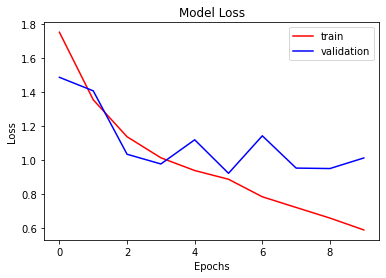

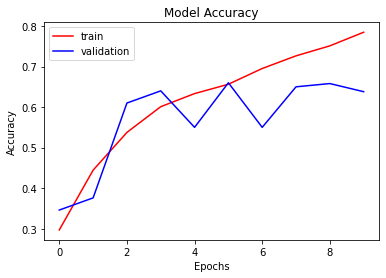

In [37]:
# Loss
plt.plot(History.history['loss'], "r")
plt.plot(History.history['val_loss'], "b")
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
plt.show()

# Accuracy
plt.plot(History.history['accuracy'], "r")
plt.plot(History.history['val_accuracy'],"b")
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])
plt.show()